In [1]:
import os
import gc
import time
import copy
import json
import random
import pathlib
import argparse
import math as m
import matplotlib
import numpy as np
from typing import Tuple
from random import randrange

from segysak.segy import segy_loader
from source.DataLoader import DataLoader
from source.test_process import Testing2DGPT, Testing2DUnet, plot_2D_visualization
from source.pre_process import create_dataset, dataset_test_creator, predict, create_patches_2D
from source.DatasetReader import DatasetReader
from source.DatasetCreator import DatasetCreator
from source.enum_types import DatasetType, DataType
from source.callbacks import cosine_schedule, TrainMonitor, weighted_categorical_crossentropy, calculate_weight_distribution


import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

from conf.config import Configuration
from hydra.core.config_store import ConfigStore
from hydra import compose, initialize
from omegaconf import OmegaConf

os.environ["CUDA_VISIBLE_DEVICES"]="0"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    
    except RuntimeError as e:
        print(e)

2024-03-31 19:41:50.633018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 19:41:50.633053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 19:41:50.633073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 19:41:50.639797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[255] = [0., 0., 1., 1.]
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='filter',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [1., 0., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='label',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 1., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cpixel',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 0., 1., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cblue',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

/tmp/ipykernel_24722/4210114844.py:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_24722/4210114844.py:19: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_24722/4210114844.py:26: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_24722/4210114844.py:32: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.reg

In [3]:
cs = ConfigStore.instance()
cs.store(name='execution_config', node=Configuration)

initialize(config_path="conf")
cfg = compose(config_name="config.yaml")

print(OmegaConf.to_yaml(cfg))

/tmp/ipykernel_24722/758786265.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")


roi_config:
  roi_size: 200
  n_spacing_pixels_roi: 30
  roi_separation_in_percentage: 0.3
  n_traces_block: 1
  random_displacement: true
model_config:
  n_epochs: 150
  n_units_lstm_layers:
  - 256
  - 128
  - 64
  n_filters_dcunet: 64
  learning_rate: 0.0001
  batch_size: 1000
  SHUFFLE_BUFFER_SIZE: 1000
  concatenate_train_val_sequences: true
  validation_split_proportion: 0.35
  augmentation: true
  cross_validation_folds: null
regularexpression:
  expr_regular_match_filenames_2d: (([0-9]{4}\-[0-9]{4})(_ANP|ANP|_Ext|Ext|_E|E|_A|A|_CPGEO|CPGEO|(_{1}[0-9]+)*)?)
  expr_regular_match_filenames_3d_sgy: ([0-9A-Za-z_]+)(.sgy)
  expr_regular_match_filenames_3d_json: ([0-9A-Za-z_]+)-([A-za-z_]+).json
gas_config:
  n_spacing_pixels_gas: 10
seed_config:
  SEED: 123
file_path_config:
  base_dir: ''
  train_json: ''
  campos_base_dir: null
output_paths:
  tensorboard: Teste_Locations_BL102
  out_directory: Teste_Locations_BL102



/local/lsantos/.conda/envs/alineGPT/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
cfg.model_config.batch_size = 200
cfg.roi_config.roi_separation_in_percentage = 0.3
cfg.roi_config.n_spacing_pixels_roi = 25
cfg.roi_config.roi_size = 256

dataset = ['gvp', 'gvca', 'gvbl']
dataset_name = dataset[0]

### Load Data

In [5]:
data_reader = DatasetReader()

training_paths = data_reader.read_dataset_file(
    dataset_file= 'json_files/' + dataset_name  +  '.json', base_dir='',
)

data_loader_2d = DataLoader(
        dataset_type=DatasetType.TRAIN,
        data_type=DataType.DATA_2D,
        data_paths=training_paths,
        config=cfg,
    )

train_data, val_data, test_data = data_loader_2d.data_list

dataset_creator = DatasetCreator(
    batch_size=cfg.model_config.batch_size,
    config=cfg,
    shuffle=True,
    reshuffle_each_iteration=True,
)

print('Seismics Loaded for TRAIN:')

train_data_samples = dataset_creator.build_samples(
    views_2d=train_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)
print('Seismics Loaded for VALIDATION:')

val_data_samples = dataset_creator.build_samples(
    views_2d=val_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)

print('Seismics Loaded for TEST:')

test_data_samples = dataset_creator.build_samples(
    views_2d=test_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)


X_patches_train, Y_patches_train = create_patches_2D(train_data_samples)
X_patches_val, Y_patches_val = create_patches_2D(val_data_samples)

#X_patches_train = standarlization_patches(X_patches_train)
#X_patches_val = standarlization_patches(X_patches_val)

X_patches_train.astype(np.float32);
Y_patches_train.astype(np.float32);
X_patches_val.astype(np.float32);
Y_patches_val.astype(np.float32);

print('\n Validation')
print(np.amax(X_patches_val))
print(np.amin(X_patches_val))
print(np.mean(X_patches_val))
print(np.std(X_patches_val))

print('\n Train')
print(np.amax(X_patches_train))
print(np.amin(X_patches_train))
print(np.mean(X_patches_train))
print(np.std(X_patches_train))

Loading 0375-1034: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Seismics Loaded for TRAIN:
+----+--------------+---------------+
|    | Seismic id   |   Num Samples |
|----+--------------+---------------|
|  0 | 0303-0070    |          3313 |
|  0 | 0303-0151    |          2056 |
|  0 | 0303-0246    |          2361 |
|  0 | 0303-0264    |          1137 |
|  0 | 0303-0348    |          1633 |
|  0 | 0303-0356    |          1345 |
|  0 | 0303-0358    |          2149 |
|  0 | 0303-0360    |          1464 |
|  0 | 0375-1028    |          1105 |
|  0 | 0375-1030    |          2017 |
|  0 | 0375-1033    |          1679 |
|  0 | 0375-1035    |          1413 |
+----+--------------+---------------+
Seismics Loaded for VALIDATION:
+----+--------------+---------------+
|    | Seismic id   |   Num Samples |
|----+--------------+---------------|
|  0 | 0303-0083    |          3112 |
|  0 | 0303-0350    |          2444 |
|  0 | 0303-0355    |           763 |
|  0 | 0303-0359    |          2305 |
|  0 | 0375-1029    |          3179 |
+----+--------------+--------

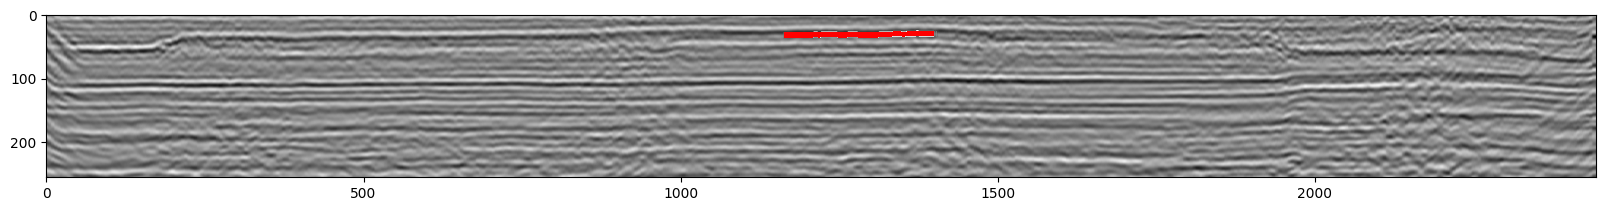

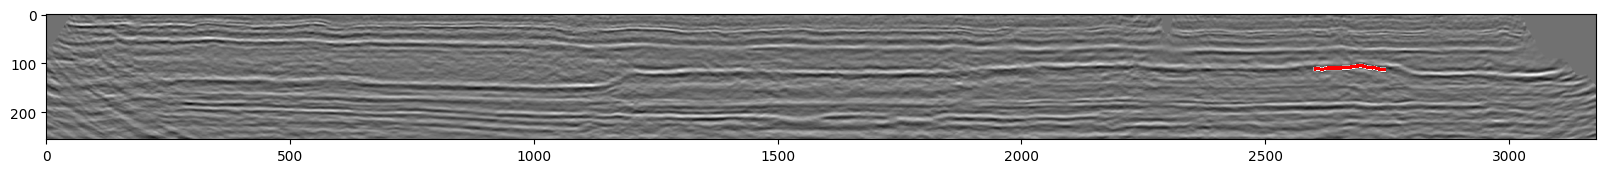

In [7]:
x_key1 = random.choice(list(val_data_samples.keys()))
x_key2 = random.choice(list(val_data_samples.keys()))

plt.figure(figsize = (20,20))
plt.imshow(val_data_samples[x_key1]['roi1'][0], cmap='gray')
plt.imshow(val_data_samples[x_key1]['roi1'][1], cmap='label')
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(val_data_samples[x_key2]['roi2'][0], cmap='gray')
plt.imshow(val_data_samples[x_key2]['roi2'][1], cmap='label')
plt.show()

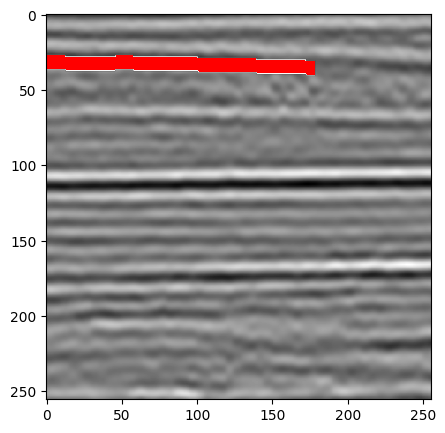

In [8]:
ID = random.randint(0, X_patches_val.shape[0])
plt.figure(figsize = (5,5))
plt.imshow(X_patches_val[ID], cmap='gray')
plt.imshow(Y_patches_val[ID], cmap='label')
plt.show()

In [9]:
def down_block(x, filters, use_maxpool = True):
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    if use_maxpool == True:
        return  tf.keras.layers.MaxPooling2D(strides= (2,2))(x), x
    else:
        return x
def up_block(x,y, filters):
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate(axis = 3)([x,y])
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x
    
def Unet(input_size = (256, 256, 1), *, classes, dropout):
    filter = [64,128,256,512, 1024]
    # encode
    input = tf.keras.layers.Input(shape = input_size)
    x, temp1 = down_block(input, filter[0])
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool= False)
    # decode 
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = tf.keras.layers.Dropout(dropout)(x)
    output = tf.keras.layers.Conv2D(classes, 1, activation= 'softmax')(x)
    model = tf.keras.Model(input, output, name = 'unet')
    model.summary()
    return model

In [10]:
def model_train(x_train, y_train, x_val, y_val, model, model_checkpoint_name, outdir, batch_size,  n_epochs=2000):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(outdir + '/' + model_checkpoint_name + ".cpk", 
                                               save_best_only=True, 
                                               save_weights_only=True, 
                                               monitor="val_loss", 
                                               verbose=1
                                            ),
        LearningRateScheduler(cosine_schedule(base_lr=1e-3, 
                                      total_steps=n_epochs, 
                                      warmup_steps=10))
       ,
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, mode='min'),
    ]

    weight_class0, weight_class1 = calculate_weight_distribution(y_train, y_val)
    loss = weighted_categorical_crossentropy(np.array([weight_class0, weight_class1]))

    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss
    )
    
    #Transform labels to one hot encodind vectors
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

    #Concatenate train and validation sequences
    x_train = np.concatenate([x_train, x_val])
    y_train = np.concatenate([y_train, y_val])

    #Shuffle sequences
    idx = np.random.permutation(y_train.shape[0])
    x_train = x_train[idx]
    y_train = y_train[idx]
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    total_n_samples = tf.data.experimental.cardinality(train_dataset)
    validation_dataset = train_dataset.take(total_n_samples // 3)# 1 third to validation

    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.batch(batch_size)
    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

    train_dataset = train_dataset.prefetch(buffer_size=280)

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=n_epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

In [11]:
model = Unet((256,256,1), classes= 2, dropout= 0.2)
model.summary()

2024-03-31 19:42:53.009366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6821 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:17:00.0, compute capability: 7.5


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [ ]:
#Cria o diretorio de escrita
dt = time.localtime()

strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

cfg.output_paths.out_directory = 'Results/' +  '2D' + '/Unet/' + dataset_name  + "/checkpoint_ " + strinstante +  "/" + 'model'
if not os.path.exists(cfg.output_paths.out_directory):
    os.makedirs(cfg.output_paths.out_directory)



weights_savename = "WeightTrained-" + strinstante
trained_model, history = model_train(X_patches_train, 
                                     Y_patches_train, 
                                     X_patches_val, 
                                     Y_patches_val, 
                                     model, 
                                     weights_savename,
                                     cfg.output_paths.out_directory,
                                     10,
                                     )
modelName = cfg.output_paths.out_directory + '/' + weights_savename + ".cpk"

Weights (1.0058092629031903, 173.1388783163551)
Number of train batches: 48
Number of validation batches: 16


2024-03-31 19:43:00.962150: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 19:43:00.962232: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 19:43:00.962274: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 19:43:00.962329: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before

Epoch 1/2000


2024-03-31 19:43:04.020411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inunet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-31 19:43:04.552165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-31 19:43:04.656293: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 19:43:04.659721: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-31 19:43:05.163110: W tensorflow/tsl/

 1/48 [..............................] - ETA: 14:13 - loss: 123.7656

2024-03-31 19:43:19.530294: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



48/48 [==============================] - ETA: 0s - loss: 50.9876

2024-03-31 19:43:49.527239: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.



Epoch 1: val_loss improved from inf to 48.56794, saving model to Results/2D/Unet/gvp/checkpoint_ 2024-03-0031-19-42-59/model/WeightTrained-2024-03-0031-19-42-59.cpk
48/48 [==============================] - 51s 694ms/step - loss: 50.9876 - val_loss: 48.5679 - lr: 1.0000e-04
Epoch 2/2000
48/48 [==============================] - ETA: 0s - loss: 25.0777
Epoch 2: val_loss improved from 48.56794 to 39.55951, saving model to Results/2D/Unet/gvp/checkpoint_ 2024-03-0031-19-42-59/model/WeightTrained-2024-03-0031-19-42-59.cpk
48/48 [==============================] - 29s 615ms/step - loss: 25.0777 - val_loss: 39.5595 - lr: 2.0000e-04
Epoch 3/2000
48/48 [==============================] - ETA: 0s - loss: 17.8930
Epoch 3: val_loss improved from 39.55951 to 37.68325, saving model to Results/2D/Unet/gvp/checkpoint_ 2024-03-0031-19-42-59/model/WeightTrained-2024-03-0031-19-42-59.cpk
48/48 [==============================] - 29s 615ms/step - loss: 17.8930 - val_loss: 37.6832 - lr: 3.0000e-04
Epoch 4/200

In [ ]:
modelBest  = Unet((256,256,1), classes=2, dropout= 0.2)

modelBest.built = True
model.load_weights(modelName)
modelBest.summary()

In [ ]:
attrListTest = []
attrListTest.append(test_data_samples)
print('TEST METRICS')
testing = Testing2DUnet(
    test_data=attrListTest,
    model=modelBest,
    save_dir=cfg.output_paths.out_directory,
    cfg=cfg
)
testing.inference()
testing.save_metrics()
testing.save_metrics_filtered()

In [ ]:
outputdir = cfg.output_paths.out_directory + '/new_plot/'

for view in test_data:
    ID = view.id
    segy_path = view.file_path
    gas_json = view.gas_horizons
    segy_path2D_json = view.label_file_path
    
    line_2D = segy_loader(segy_path)
    shift = line_2D.twt[0]
    for i in range(len(line_2D.twt)):
        line_2D.twt.values[i] = line_2D.twt.values[i] - shift

    segy_infe_path2D = cfg.output_paths.out_directory + '/Sgy_Inference/' +  'INFERENCE_' + ID + '.sgy'
    cube_infe2D = segy_loader(segy_infe_path2D)
    shift = cube_infe2D.twt[0]
    
    for i in range(len(cube_infe2D.twt)): 
        cube_infe2D.twt.values[i] = cube_infe2D.twt.values[i] - shift
    
    plot_2D_visualization(line_2D, cube_infe2D, outputdir, 900, 1650, segy_path2D_json)

In [ ]:
cfg.output_paths.out_directory